In [1]:
import numpy as np
import json
import random
import argparse
import os

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.distributions.multivariate_normal as mvn
from torch.nn.utils import spectral_norm

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image, ImageDraw

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
seed = 1123
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  1123


In [4]:
# batch_size = args.batch_size
# lrd = args.learning_rate_disc
# lrg = args.learning_rate_gen
# epochs = args.epochs

batch_size = 256
lr = 1e-4
epochs = 10

betas = [0.5, 0.999]

# Check for cuda
use_cuda = torch.cuda.is_available()

EPS = 1e-6

In [5]:
class Encoder(nn.Module):
    def __init__(self, in_channels = 1, num_hiddens = 128, hidden_dim=64, z=10):
        super(Encoder, self).__init__()

        self.num_hiddens = num_hiddens
        self.z = z

        self._conv_0 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1)

        self._conv_1 = nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1)


        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)


        self._conv_3 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)

        self._fc1 = nn.Linear(1024, hidden_dim)

        self.fc_mean = nn.Linear(hidden_dim, self.z)
        self.fc_logvar = nn.Linear(hidden_dim, self.z)

    def forward(self, inputs):

        x1 = F.leaky_relu(self._conv_0(inputs), 0.2, inplace=True)

        x2 = self._conv_1(x1)
        x2 = F.leaky_relu(x2, 0.2, inplace=True)

        x3 = self._conv_2(x2)
        x3 = F.leaky_relu(x3, 0.2, inplace=True)

        x4 = self._conv_3(x3)
        x4 = F.leaky_relu(x4, 0.2, inplace=True)

        x5 = self._fc1(x4.view(-1, self.num_hiddens*8))
        x5 = F.leaky_relu(x5, 0.2, inplace=True)

        mean = self.fc_mean(x5)
        logvar = self.fc_logvar(x5)
        return mean, logvar

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim = 10, hidden_dim = 256, num_hiddens = 128, out_channels=1):
        super(Decoder, self).__init__()

        self.num_hiddens = num_hiddens

        self._fc1 = nn.Linear(latent_dim, hidden_dim//2)

        self._fc2 = nn.Linear(hidden_dim//2, 1024)

        # the exact inverse of the encoder
        self._tconv2 = nn.ConvTranspose2d(num_hiddens//2, num_hiddens//2, kernel_size=4, stride=2, padding =1)

        self._tconv3 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=num_hiddens//4,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._tconv4 = nn.ConvTranspose2d(in_channels=num_hiddens//4,
                                                out_channels=num_hiddens//4,
                                                kernel_size=4,
                                                stride=2, padding=1)


        self._tconv5 = nn.ConvTranspose2d(in_channels=num_hiddens//4,
                                                out_channels=out_channels,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._fc1(inputs)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._fc2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._tconv2(x.view(-1,64,4,4))
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._tconv3(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._tconv4(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        return torch.sigmoid(self._tconv5(x))

In [7]:
class PrototypeEncoder(nn.Module):
    def __init__(self, x_dim=(1,64,64), hid_dim=64, z_dim=2, num_channels=2):
        super(PrototypeEncoder, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
            )
        self.conv1 = conv_block(num_channels, hid_dim//2)
        self.conv2 = conv_block(hid_dim//2, hid_dim)
        self.conv3 = conv_block(hid_dim, hid_dim*2)
        self.conv4_z = conv_block(hid_dim*2, z_dim)
        self.linear_z = nn.Linear(z_dim*x_dim[-1]//4, z_dim)
        self.linear_c = nn.Linear(z_dim*x_dim[-1]//4, 10)

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4_z(x)
        z = self.linear_z(x.view(x.shape[0],-1))
        y = self.linear_c(x.view(x.shape[0],-1))
        return z, y

In [8]:
class Protonet(nn.Module):
    def __init__(self, encoder):
        super(Protonet, self).__init__()

        self.encoder = encoder

In [9]:
class VAE(nn.Module):
    def __init__(self, img_size = (1,64,64), enc_hidden = 256, hidden_dim = 64, dis_hidden = 32, z = 5, dec_hidden = 256, use_cuda=False):

        super(VAE, self).__init__()
        self.use_cuda = use_cuda

        # Parameters
        self.img_size = img_size
        self.num_pixels = img_size[0] * img_size[1] * img_size[2]
        self.z = z
        self.channels = img_size[0]

        # Define the encoder
        self.img_to_features = Encoder(in_channels=self.channels, hidden_dim=hidden_dim, z=self.z)

        # Define decoder
        self.features_to_img = Decoder(self.z, out_channels=self.channels)

    def forward(self, data):
        mean, logvar = self.encode(data)
        sample = self.reparameterize([mean, logvar])
        recons = self.decode(sample)
        return recons, [mean, logvar]
    
    def encode(self,data):
        return self.img_to_features(data)
    
    def decode(self,data):
        return self.features_to_img(data)
        
    def representation_function(self,x):
        mean, logvar = self.img_to_features(x)
        return mean

    def reparameterize(self, latent_disc):
        mean, logvar = latent_disc
        std = torch.exp(0.5 * logvar)
        eps = torch.zeros(std.size()).normal_()
        if self.use_cuda:
            eps = eps.cuda()
        return mean + std * eps

In [10]:
if __name__ == "__main__":
    batch_size = 256
    img_size = (3,64,64)
    z=10
    model = VAE(img_size=img_size, z=z, use_cuda=use_cuda)
    if use_cuda:
        model.cuda()
    checkpoint = torch.load('../mpi_09_26_2022/weights_e30_z10_b1_g10_lr[0.0001, 0.0001, 5e-05]_bs128_s8300_r[2, 2, 2, 0]_d3',map_location=torch.device('cpu'))
    plots = ['samples', 'reconstruct-traverse']
    loss_file = '../mpi_09_26_2022/losses_e30_z10_b1_g10_lr[0.0001, 0.0001, 5e-05]_bs128_s8300_r[2, 2, 2, 0]_d3.json'
    
    prototype = PrototypeEncoder(x_dim=img_size,hid_dim=64, z_dim=3, num_channels=2*img_size[0])
    protonet = Protonet(prototype)
    
    #

In [11]:
train_data = torch.from_numpy(np.load("../mpi3d_real_test.npz")['images']/255.).permute(0,3,1,2).float()

train_labels = torch.randn((train_data.shape[0],1)).float()

test_dataset = torch.utils.data.TensorDataset(train_data,train_labels)


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle=True,
drop_last=True)

print(len(test_loader.dataset))

100


In [12]:
################## yann visualizations ########################################

In [13]:
class Visualizer():
    def __init__(self, model, model_dir, loss_file, 
                 save_images=True,
                 loss_of_interest=None,
                 display_loss_per_dim=False,
                 max_traversal=0.475,  # corresponds to ~2 for standard normal
                 upsample_factor=1):
        """
        Visualizer is used to generate images of samples, reconstructions,
        latent traversals and so on of the trained model.
        Parameters
        ----------
        model : disvae.vae.VAE
        dataset : str
            Name of the dataset.
        model_dir : str
            The directory that the model is saved to and where the images will
            be stored.
        save_images : bool, optional
            Whether to save images or return a tensor.
        loss_of_interest : str, optional
            The loss type (as saved in the log file) to order the latent dimensions by and display.
        display_loss_per_dim : bool, optional
            if the loss should be included as text next to the corresponding latent dimension images.
        max_traversal: float, optional
            The maximum displacement induced by a latent traversal. Symmetrical
            traversals are assumed. If `m>=0.5` then uses absolute value traversal,
            if `m<0.5` uses a percentage of the distribution (quantile).
            E.g. for the prior the distribution is a standard normal so `m=0.45` c
            orresponds to an absolute value of `1.645` because `2m=90%%` of a
            standard normal is between `-1.645` and `1.645`. Note in the case
            of the posterior, the distribution is not standard normal anymore.
        upsample_factor : floar, optional
            Scale factor to upsample the size of the tensor
        """
        self.model = model
        self.device = next(self.model.parameters()).device
        self.latent_dim = self.model.z
        self.max_traversal = max_traversal
        self.save_images = save_images
        self.model_dir = model_dir 
        self.dataset = 'dsprites'
        self.upsample_factor = upsample_factor
        if loss_of_interest is not None:
            # get this from your loss file
            self.losses = read_loss_from_file(loss_file)

    def _get_traversal_range(self, mean=0, std=1):
        """Return the corresponding traversal range in absolute terms."""
        max_traversal = self.max_traversal

        if max_traversal < 0.5:
            max_traversal = (1 - 2 * max_traversal) / 2  # from 0.45 to 0.05
            max_traversal = stats.norm.ppf(max_traversal, loc=mean, scale=std)  # from 0.05 to -1.645

        # symmetrical traversals
        return (-1 * max_traversal, max_traversal)

    def _traverse_line(self, idx, n_samples, data=None):
        """Return a (size, latent_size) latent sample, corresponding to a traversal
        of a latent variable indicated by idx.
        Parameters
        ----------
        idx : int
            Index of continuous dimension to traverse. If the continuous latent
            vector is 10 dimensional and idx = 7, then the 7th dimension
            will be traversed while all others are fixed.
        n_samples : int
            Number of samples to generate.
        data : torch.Tensor or None, optional
            Data to use for computing the posterior. Shape (N, C, H, W). If
            `None` then use the mean of the prior (all zeros) for all other dimensions.
        """
        if data is None:
            # mean of prior for other dimensions
            samples = torch.zeros(n_samples, self.latent_dim)
            traversals = torch.linspace(*self._get_traversal_range(), steps=n_samples)

        else:
            if data.size(0) > 1:
                raise ValueError("Every value should be sampled from the same posterior, but {} datapoints given.".format(data.size(0)))

            with torch.no_grad():
                post_mean, post_logvar = self.model.encode(data.to(self.device))
                samples = self.model.reparameterize([post_mean, post_logvar])
                samples = samples.cpu().repeat(n_samples, 1)
                post_mean_idx = post_mean.cpu()[0, idx]
                post_std_idx = torch.exp(post_logvar / 2).cpu()[0, idx]

            # travers from the gaussian of the posterior in case quantile
            traversals = torch.linspace(*self._get_traversal_range(mean=post_mean_idx,
                                                                   std=post_std_idx),
                                        steps=n_samples)

        for i in range(n_samples):
            samples[i, idx] = traversals[i]

        return samples

    def _save_or_return(self, to_plot, size, filename, is_force_return=False):
        """Create plot and save or return it."""
        to_plot = F.interpolate(to_plot, scale_factor=self.upsample_factor)

        if size[0] * size[1] != to_plot.shape[0]:
            raise ValueError("Wrong size {} for datashape {}".format(size, to_plot.shape))

        # `nrow` is number of images PER row => number of col
        kwargs = dict(nrow=size[1], pad_value=1)
        if self.save_images and not is_force_return:
            filename = os.path.join(self.model_dir, filename)
            save_image(to_plot, filename, **kwargs)
        else:
            return make_grid_img(to_plot, **kwargs)

    def _decode_latents(self, latent_samples):
        """Decodes latent samples into images.
        Parameters
        ----------
        latent_samples : torch.autograd.Variable
            Samples from latent distribution. Shape (N, L) where L is dimension
            of latent distribution.
        """
        latent_samples = latent_samples.to(self.device)
        return self.model.decode(latent_samples).cpu()

    def generate_samples(self, size=(8, 8)):
        """Plot generated samples from the prior and decoding.
        Parameters
        ----------
        size : tuple of ints, optional
            Size of the final grid.
        """
        prior_samples = torch.randn(size[0] * size[1], self.latent_dim)
        generated = self._decode_latents(prior_samples)
        return self._save_or_return(generated.data, size, PLOT_NAMES["generate_samples"])

    def data_samples(self, data, size=(8, 8)):
        """Plot samples from the dataset
        Parameters
        ----------
        data : torch.Tensor
            Data to be reconstructed. Shape (N, C, H, W)
        size : tuple of ints, optional
            Size of the final grid.
        """
        data = data[:size[0] * size[1], ...]
        return self._save_or_return(data, size, PLOT_NAMES["data_samples"])

    def reconstruct(self, data, size=(8, 8), is_original=True, is_force_return=False):
        """Generate reconstructions of data through the model.
        Parameters
        ----------
        data : torch.Tensor
            Data to be reconstructed. Shape (N, C, H, W)
        size : tuple of ints, optional
            Size of grid on which reconstructions will be plotted. The number
            of rows should be even when `is_original`, so that upper
            half contains true data and bottom half contains reconstructions.contains
        is_original : bool, optional
            Whether to exclude the original plots.
        is_force_return : bool, optional
            Force returning instead of saving the image.
        """
        if is_original:
            if size[0] % 2 != 0:
                raise ValueError("Should be even number of rows when showing originals not {}".format(size[0]))
            n_samples = size[0] // 2 * size[1]
        else:
            n_samples = size[0] * size[1]

        with torch.no_grad():
            originals = data.to(self.device)[:n_samples, ...]
            recs,_ = self.model(originals)

        originals = originals.cpu()
        recs = recs.view(-1, *self.model.img_size).cpu()

        to_plot = torch.cat([originals, recs]) if is_original else recs
        return self._save_or_return(to_plot, size, PLOT_NAMES["reconstruct"],
                                    is_force_return=is_force_return)

    def traversals(self,
                   data=None,
                   is_reorder_latents=False,
                   n_per_latent=8,
                   n_latents=None,
                   is_force_return=False):
        """Plot traverse through all latent dimensions (prior or posterior) one
        by one and plots a grid of images where each row corresponds to a latent
        traversal of one latent dimension.
        Parameters
        ----------
        data : bool, optional
            Data to use for computing the latent posterior. If `None` traverses
            the prior.
        n_per_latent : int, optional
            The number of points to include in the traversal of a latent dimension.
            I.e. number of columns.
        n_latents : int, optional
            The number of latent dimensions to display. I.e. number of rows. If `None`
            uses all latents.
        is_reorder_latents : bool, optional
            If the latent dimensions should be reordered or not
        is_force_return : bool, optional
            Force returning instead of saving the image.
        """
        n_latents = n_latents if n_latents is not None else self.model.latent_dim
        latent_samples = [self._traverse_line(dim, n_per_latent, data=data)
                          for dim in range(self.latent_dim)]
        decoded_traversal = self._decode_latents(torch.cat(latent_samples, dim=0))

        if is_reorder_latents:
            n_images, *other_shape = decoded_traversal.size()
            n_rows = n_images // n_per_latent
            decoded_traversal = decoded_traversal.reshape(n_rows, n_per_latent, *other_shape)
            decoded_traversal = sort_list_by_other(decoded_traversal, self.losses)
            decoded_traversal = torch.stack(decoded_traversal, dim=0)
            decoded_traversal = decoded_traversal.reshape(n_images, *other_shape)
            
        decoded_traversal = decoded_traversal[range(n_per_latent * n_latents), ...]

        size = (n_latents, n_per_latent)
        sampling_type = "prior" if data is None else "posterior"
        filename = "{}_{}".format(sampling_type, PLOT_NAMES["traversals"])

        return self._save_or_return(decoded_traversal.data, size, filename,
                                    is_force_return=is_force_return)

    def reconstruct_traverse(self, data,
                             is_posterior=True,
                             n_per_latent=10,
                             n_latents=None,
                             is_show_text=True):
        """
        Creates a figure whith first row for original images, second are
        reconstructions, rest are traversals (prior or posterior) of the latent
        dimensions.
        Parameters
        ----------
        data : torch.Tensor
            Data to be reconstructed. Shape (N, C, H, W)
        n_per_latent : int, optional
            The number of points to include in the traversal of a latent dimension.
            I.e. number of columns.
        n_latents : int, optional
            The number of latent dimensions to display. I.e. number of rows. If `None`
            uses all latents.
        is_posterior : bool, optional
            Whether to sample from the posterior.
        is_show_text : bool, optional
            Whether the KL values next to the traversal rows.
        """
        n_latents = n_latents if n_latents is not None else self.model.latent_dim

        reconstructions = self.reconstruct(data[:2 * n_per_latent, ...],
                                           size=(2, n_per_latent),
                                           is_force_return=True)
        traversals = self.traversals(data=data[7:8, ...] if is_posterior else None,
                                     is_reorder_latents=True,
                                     n_per_latent=n_per_latent,
                                     n_latents=n_latents,
                                     is_force_return=True)

        concatenated = np.concatenate((reconstructions, traversals), axis=0)
        concatenated = Image.fromarray(concatenated)
        concatenated.show()

        if is_show_text:
            losses = sorted(self.losses, reverse=True)[:n_latents]
            labels = ['orig', 'recon'] + ["KL={:.4f}".format(l) for l in losses]
            concatenated = add_labels(concatenated, labels)

        filename = os.path.join(self.model_dir, PLOT_NAMES["reconstruct_traverse"])
        concatenated.save(filename)

In [14]:
def load_weights(model, checkpoint):
    model.img_to_features.load_state_dict(checkpoint['encoder'])
    model.features_to_img.load_state_dict(checkpoint['decoder'])
    model.eval()
    return model

def make_grid_img(tensor, **kwargs):
    """Converts a tensor to a grid of images that can be read by imageio.
    Notes
    -----
    * from in https://github.com/pytorch/vision/blob/master/torchvision/utils.py
    Parameters
    ----------
    tensor (torch.Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)
        or a list of images all of the same size.
    kwargs:
        Additional arguments to `make_grid_img`.
    """
    grid = make_grid(tensor, **kwargs)
    img_grid = grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0)
    img_grid = img_grid.to('cpu', torch.uint8).numpy()
    return img_grid


# def get_samples
def get_samples(dataset, num_samples, idcs=[]):
    """ Generate a number of samples from the dataset.
    Parameters
    ----------
    dataset : str
        The name of the dataset.
    num_samples : int, optional
        The number of samples to load from the dataset
    idcs : list of ints, optional
        List of indices to of images to put at the begning of the samples.
    """
    data_loader = torch.utils.data.DataLoader(dataset,
                                  batch_size=1,
                                  shuffle=idcs is None)

    idcs += random.sample(range(len(data_loader.dataset)), num_samples - len(idcs))
    samples = torch.stack([data_loader.dataset[i][0] for i in idcs], dim=0)
    print("Selected idcs: {}".format(idcs))

    return samples

def sort_list_by_other(to_sort, other, reverse=True):
    """Sort a list by an other."""
    return [el for _, el in sorted(zip(other, to_sort), reverse=reverse)]

def read_loss_from_file(loss_file):
    with open(loss_file) as f:
        data = json.load(f)
    kllist =[]
    for key in list(data):
        if 'kl_' in key:
            if 'kl_z' not in key:
                kllist.append(np.sum(data[key][-100:])/100)
    return kllist

def add_labels(input_image, labels):
    """Adds labels next to rows of an image.
    Parameters
    ----------
    input_image : image
        The image to which to add the labels
    labels : list
        The list of labels to plot
    """
    new_width = input_image.width + 100
    new_size = (new_width, input_image.height)
    new_img = Image.new("RGB", new_size, color='white')
    new_img.paste(input_image, (0, 0))
    draw = ImageDraw.Draw(new_img)

    for i, s in enumerate(labels):
        draw.text(xy=(new_width - 100 + 0.005,
                      int((i / len(labels) + 1 / (2 * len(labels))) * input_image.height)),
                  text=s,
                  fill=(0, 0, 0))

    return new_img

In [15]:
PLOT_NAMES = dict(generate_samples="samples.png",
                  data_samples="data_samples.png",
                  reconstruct="reconstruct.png",
                  traversals="traversals.png",
                  reconstruct_traverse="reconstruct_traverse.png")
n_rows = z
#n_rows = model.latent_dim
n_cols = 10

#model = VAE(img_size=img_size, z1=2, z2=10, use_cuda=use_cuda)
model = load_weights(model, checkpoint)

dataset = 'dsprites'
    
viz = Visualizer(model=model,
                 model_dir='',
                 max_traversal=2,
                 loss_of_interest='kl_loss', loss_file=loss_file,
                 upsample_factor=1) 
size = (n_rows, n_cols)
# same samples for all plots: sample max then take first `x`data  for all plots
num_samples = n_cols * n_rows
    
samples = get_samples(test_dataset, num_samples)
    
if "all" in plots:
    plots = [p for p in PLOT_TYPES if p != "all"]

# mostly call it with reconstruct-traverse

for plot_type in plots:
    if plot_type == 'generate-samples':
        viz.generate_samples(size=size)
    elif plot_type == 'data-samples':
        viz.data_samples(samples, size=size)
    elif plot_type == "reconstruct":
        viz.reconstruct(samples, size=size)
    elif plot_type == "reconstruct-traverse":
        viz.reconstruct_traverse(samples,
                                 is_posterior=True,
                                 n_latents=n_rows,
                                 n_per_latent=n_cols,
                                 is_show_text=True)

Selected idcs: [35, 38, 71, 65, 1, 64, 5, 59, 37, 4, 8, 20, 62, 0, 86, 27, 75, 41, 92, 58, 72, 45, 55, 29, 61, 2, 51, 89, 34, 49, 83, 82, 32, 57, 87, 99, 21, 78, 40, 6, 60, 19, 95, 18, 11, 14, 91, 36, 28, 24, 17, 23, 31, 9, 13, 54, 48, 46, 85, 52, 67, 97, 42, 3, 25, 79, 90, 94, 93, 33, 16, 26, 96, 84, 73, 50, 12, 70, 76, 80, 7, 22, 98, 81, 30, 74, 66, 77, 43, 68, 53, 88, 39, 44, 69, 10, 47, 56, 15, 63]


In [16]:
##### end yann visualizations ##############################################################

In [17]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

model.img_to_features.load_state_dict(checkpoint['encoder'])
model.features_to_img.load_state_dict(checkpoint['decoder'])
#protonet.load_state_dict(checkpoint['proto'])

model.eval()

(valid_originals, labels) = next(iter(test_loader))
valid_originals = valid_originals.to(device)
latent_dist = model.encode(valid_originals)
latent_sample = latent_dist[0]
valid_reconstructions = model.decode(latent_sample)

In [18]:
# c = 0
# import matplotlib.pyplot as plt
# plt.scatter(latent_dist[c][0].detach().numpy(), latent_dist[c][1].detach().numpy()) 
# #             c = labels[:,0,5].detach().numpy().tolist())
# # plt.scatter(latent_dist[c][1].detach().numpy(), np.zeros((32,)), 
# #             c = labels[:,0,5].detach().numpy().tolist())

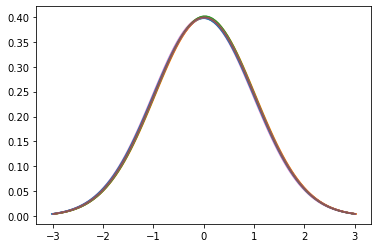

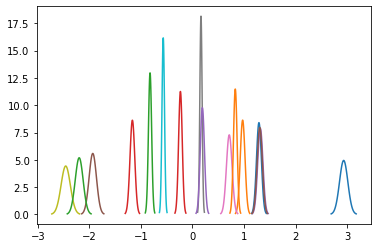

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math


lat=8
for i in range(16):
    mu = latent_dist[0][i,lat].detach().numpy()
    variance = latent_dist[1][i,lat].exp().detach().numpy()
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    #plt.xlim([-2,2])
    plt.plot(x, stats.norm.pdf(x, mu, sigma))#, c = (labels[i,5].detach().numpy().tolist(),0.2,0.5))
plt.show()
lat=9
for i in range(16):
    mu = latent_dist[0][i,lat].detach().numpy()
    variance = latent_dist[1][i,lat].exp().detach().numpy()
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))#, c = (labels[i,3].detach().numpy().tolist(),0.2,0.5))
plt.show()

In [20]:
# print(latent_dist[1])

In [21]:
def show_images_grid(imgs_, num_images=64):
    imgs_ = imgs_.numpy()
    #ncols = int(np.ceil(num_images**0.5))
    #nrows = int(np.ceil(num_images / ncols))
    ncols=10
    nrows=10
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r', interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

In [22]:
# samp = latent_sample[3]
# s = samp.repeat(40,1)

# b = torch.linspace(-2,2,40)
# s[:,9] = b.view(40,)
# show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1,nrow=10))

## s = samp.repeat(10,1)

b = torch.linspace(-1,2,10)
s[:,9] = b.view(10,)
show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1,nrow=10))

In [23]:
# s = samp.repeat(40,1)
# s[:,4] = b.view(40,)
# show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1))

In [24]:
# s = samp.repeat(40,1)
# s[:,7] = b.view(40,)
# show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1))

In [25]:
# s = samp.repeat(40,1)
# s[:,9] = b.view(40,)
# show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1))

In [26]:
# import matplotlib.pyplot as plt
# lis = test_labels.detach().numpy()[:,-1].tolist()
# liss = [x/32 for x in lis]
# plt.scatter(latent_dist[0].detach().numpy(), np.zeros((32,)), 
#             c = liss)

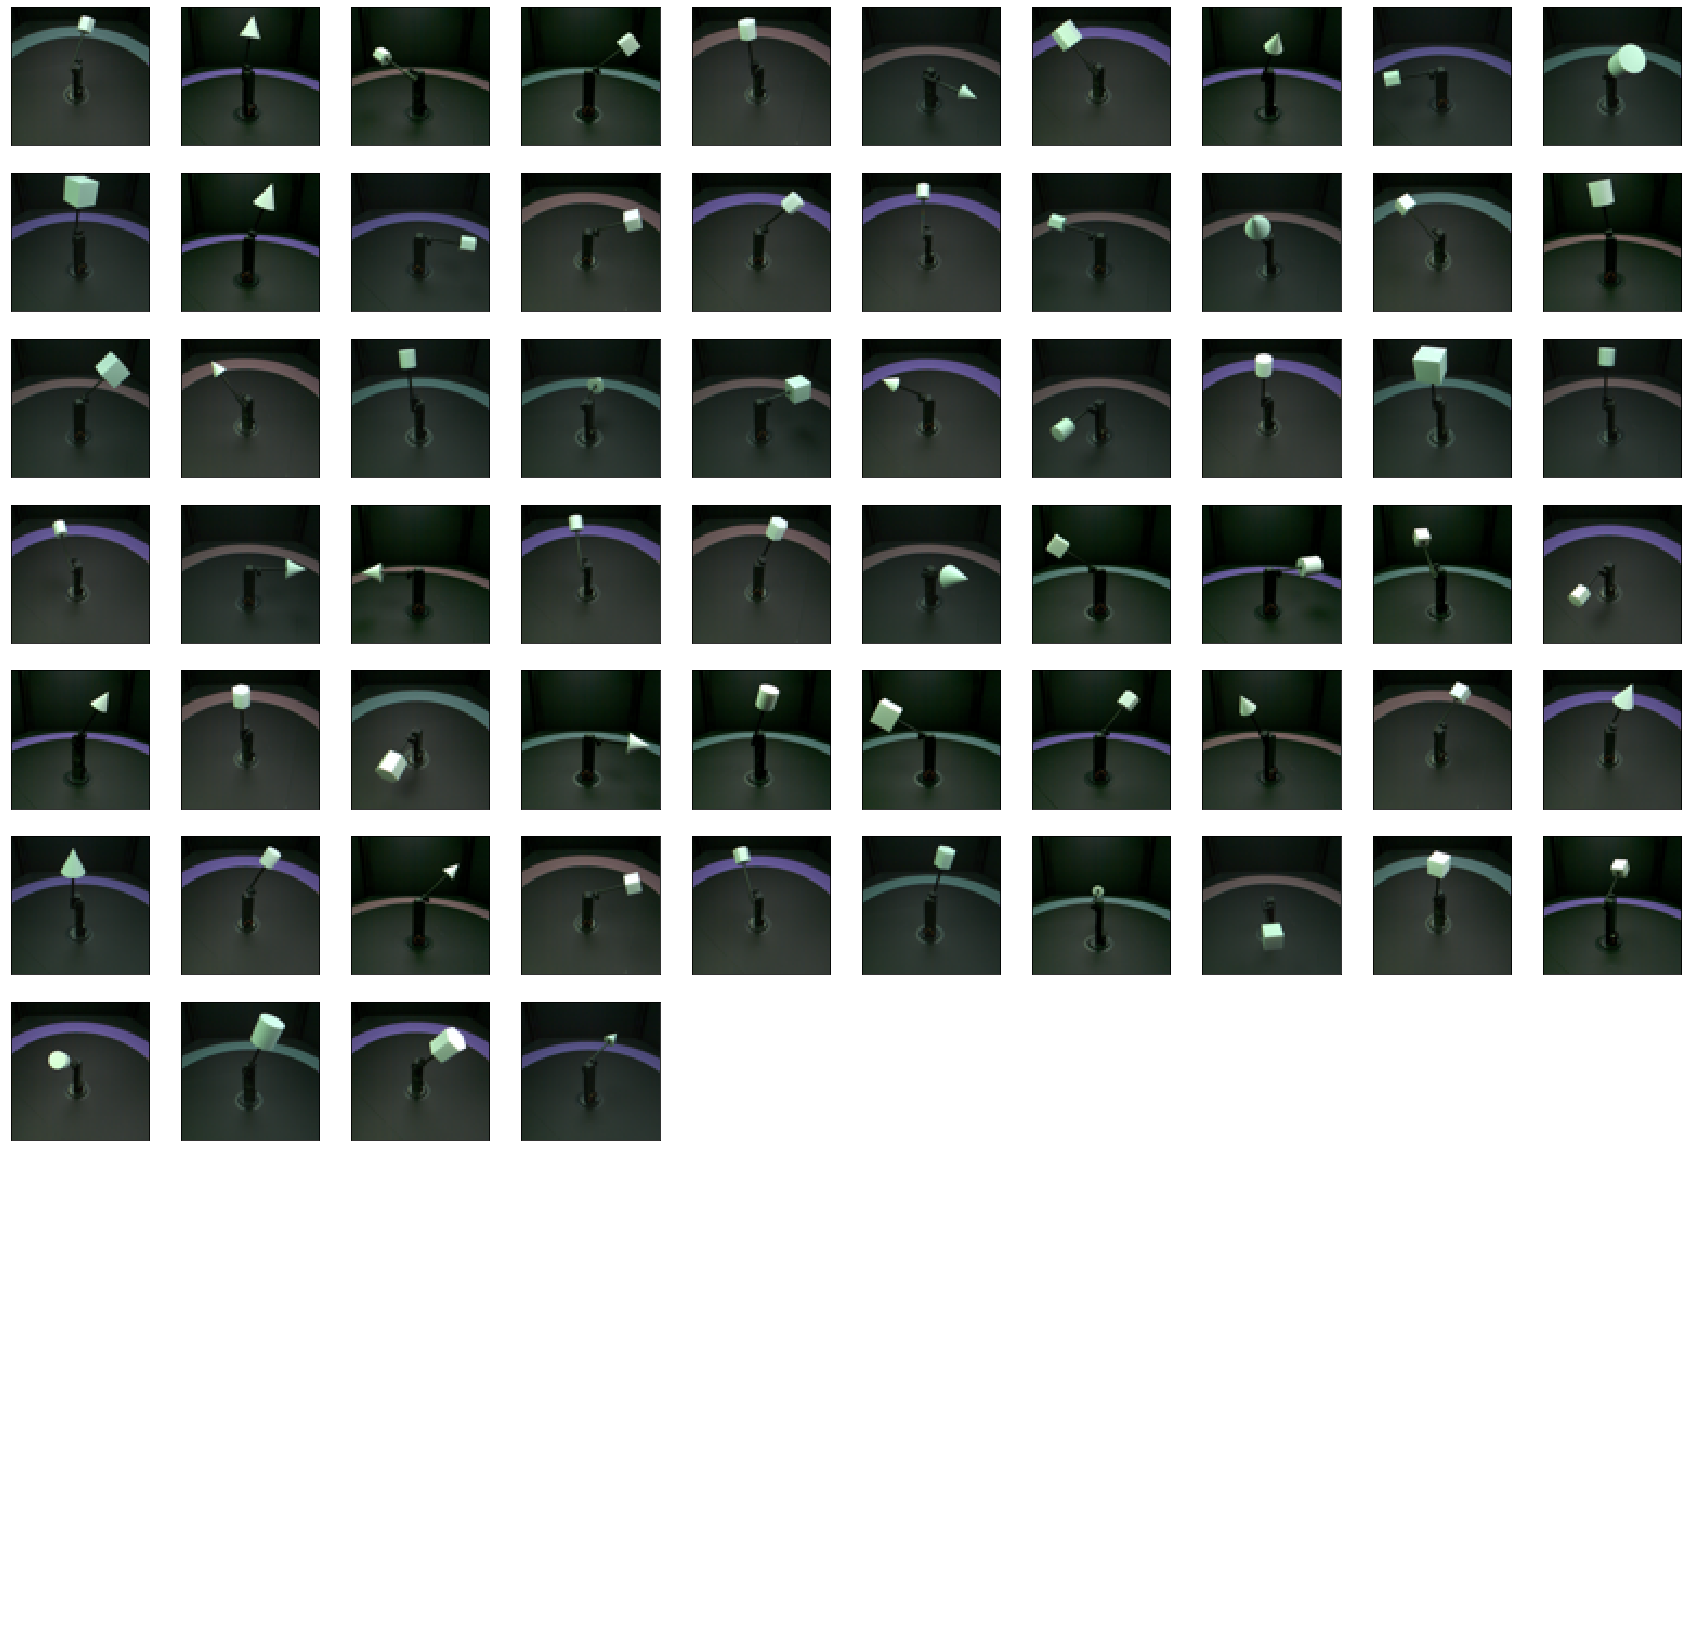

In [27]:
show_images_grid(valid_originals.permute(0,2,3,1).cpu().data)

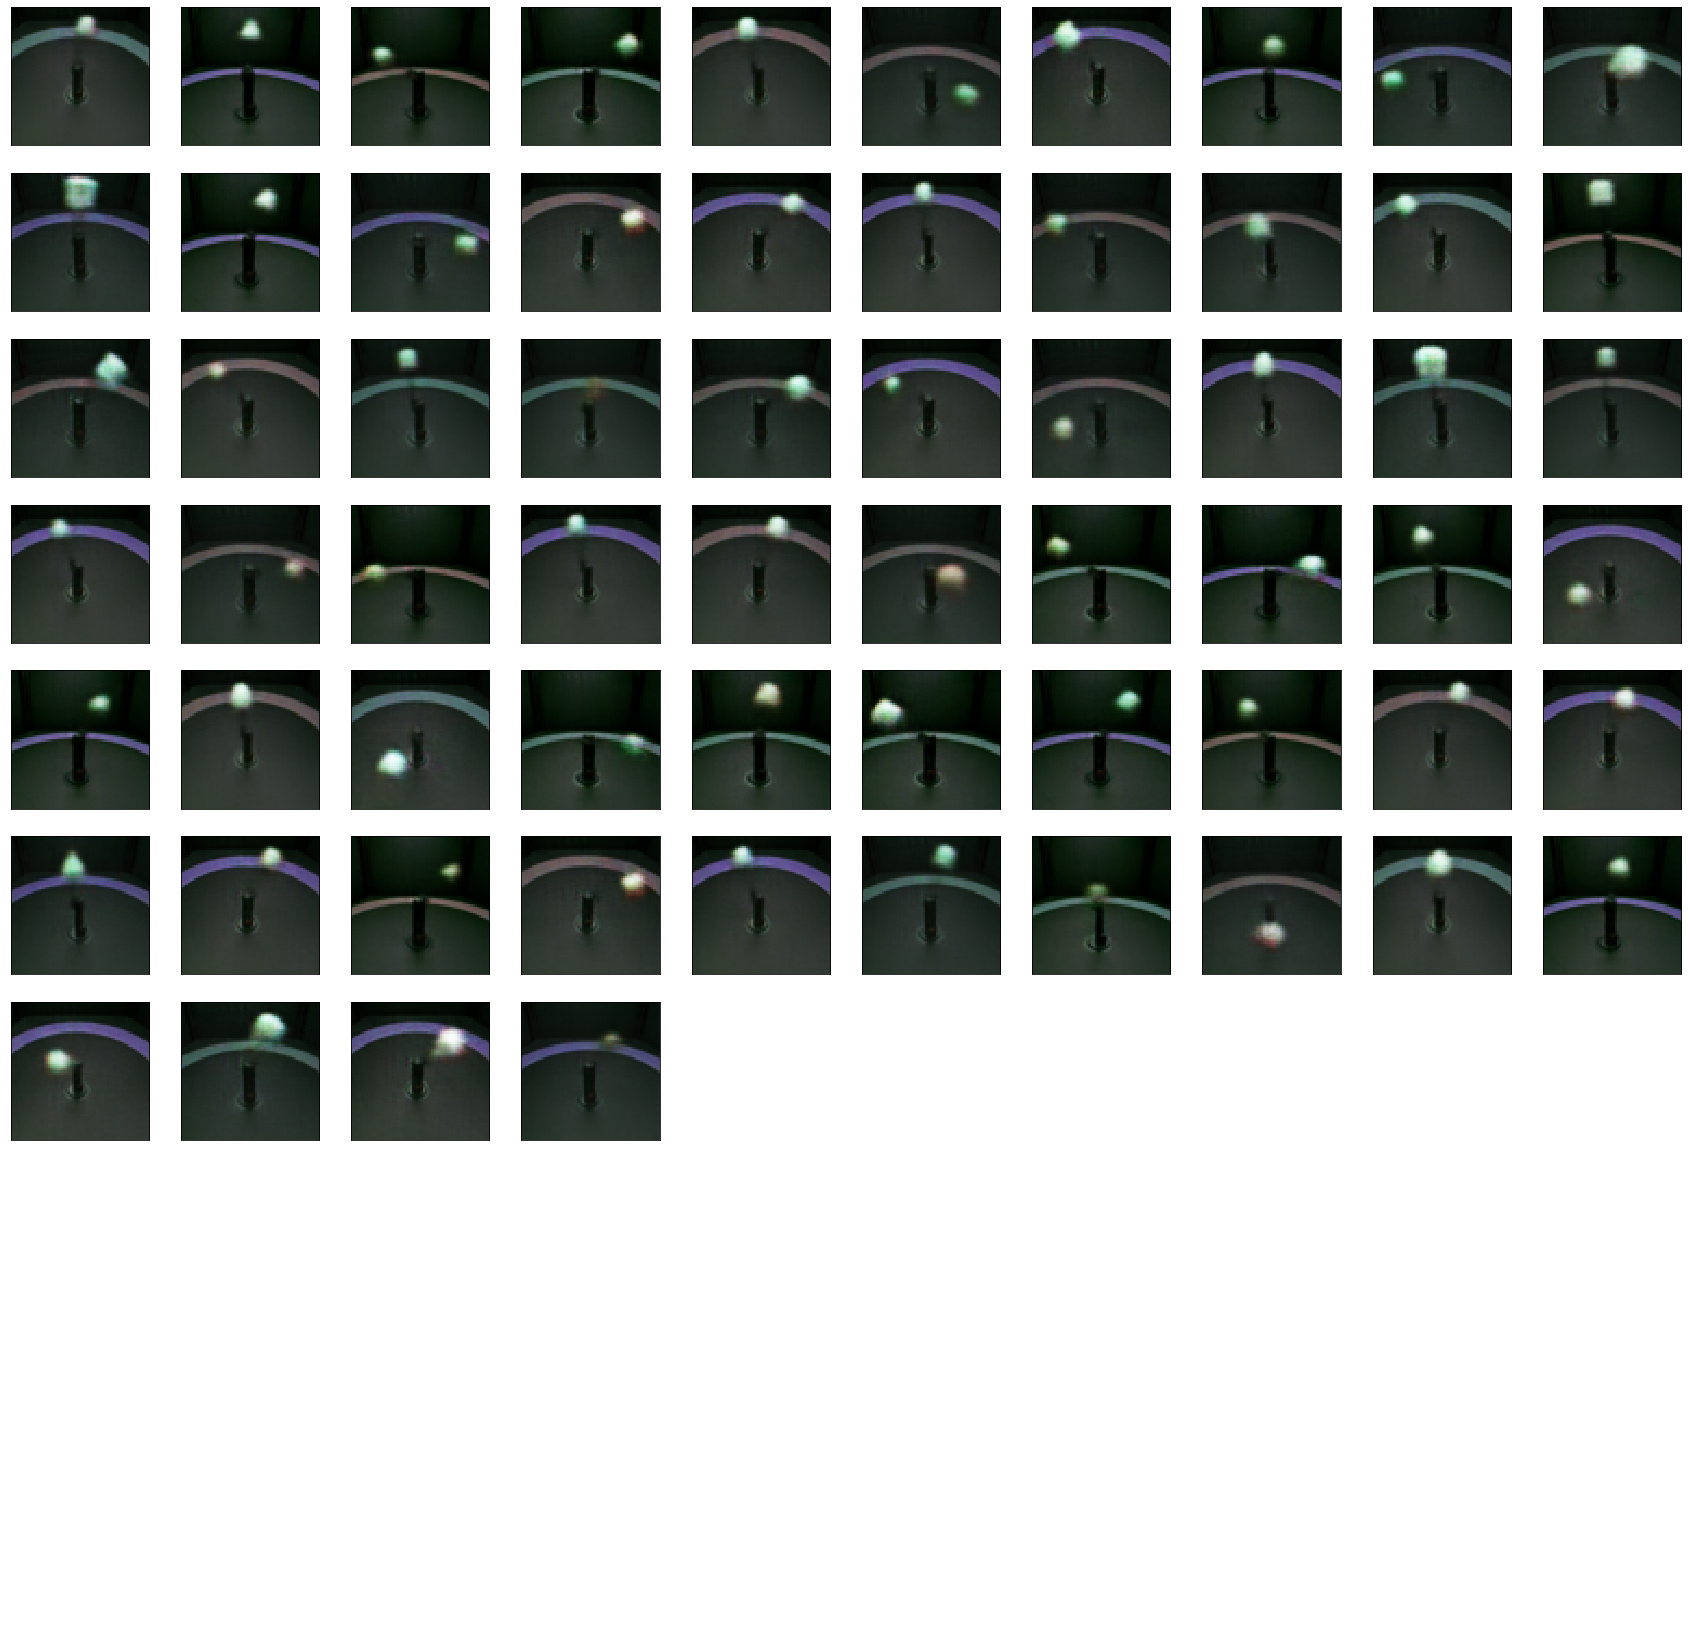

In [28]:
show_images_grid(valid_reconstructions.permute(0,2,3,1).cpu().data)

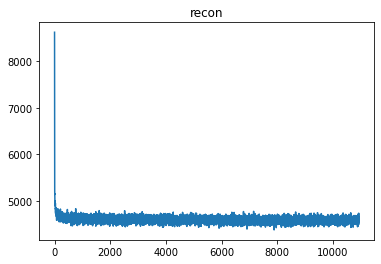

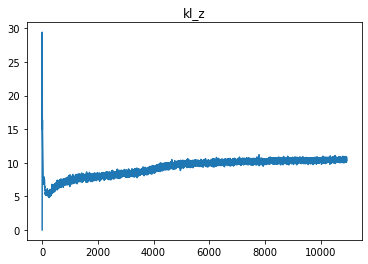

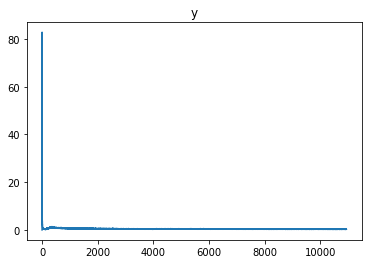

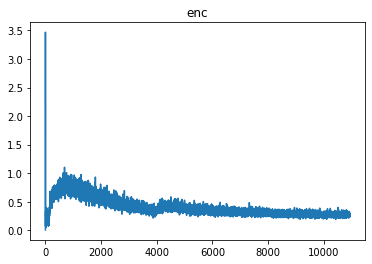

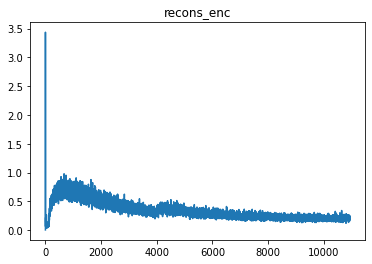

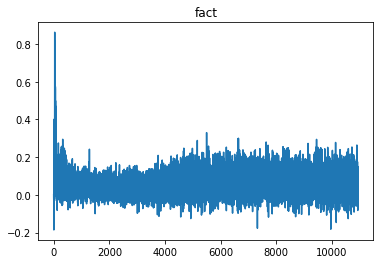

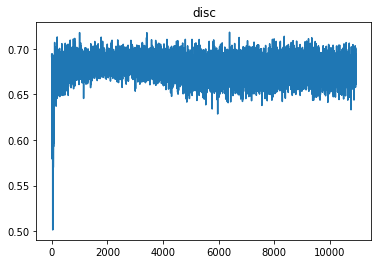

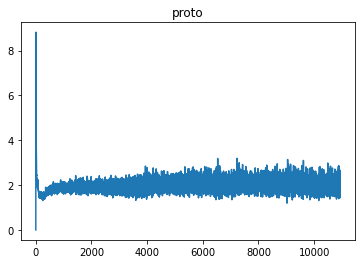

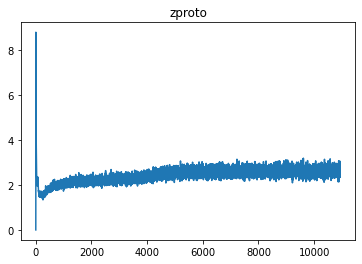

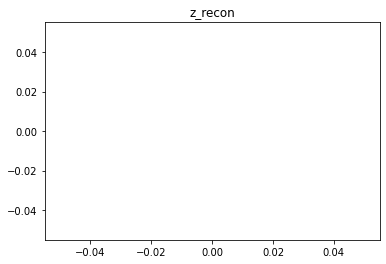

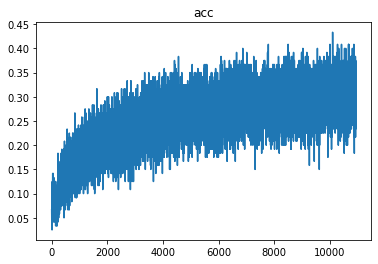

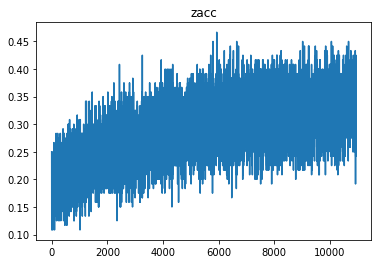

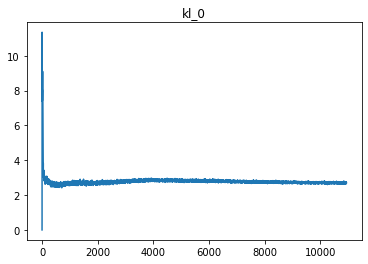

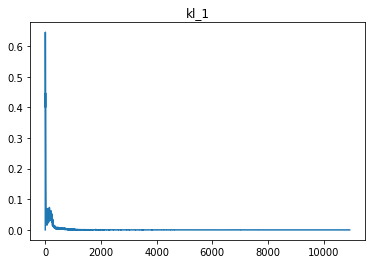

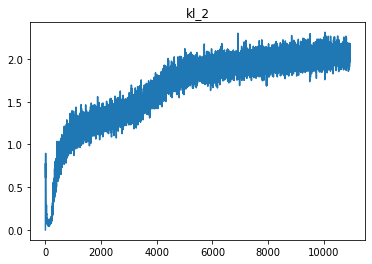

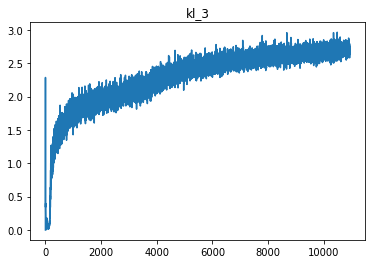

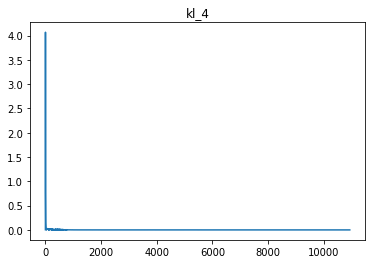

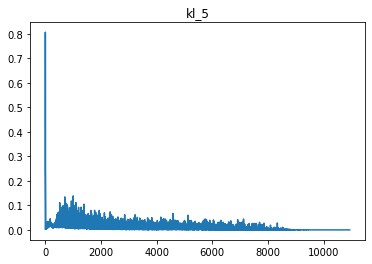

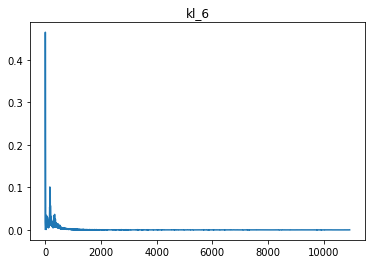

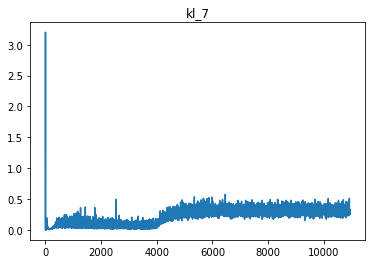

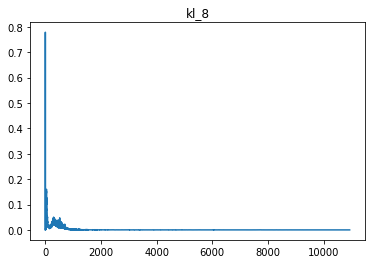

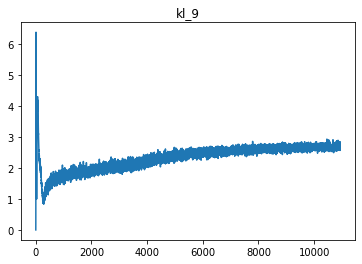

In [29]:
import json
import matplotlib.pyplot as plt

with open(loss_file) as f:
    data = json.load(f)

for key in list(data):
    plt.plot(data[key])
    plt.title(key)
    plt.show()

In [30]:
from matplotlib import pyplot as plt
import numpy as np
import h5py

In [31]:
# get the shapes dataset
# load dataset
dataset = h5py.File('../3dshapes/3dshapes.h5', 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000

_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}

<KeysViewHDF5 ['images', 'labels']>


In [32]:
# methods for sampling unconditionally/conditionally on a given factor
def get_index(factors):
    """ Converts factors to indices in range(num_data)
    Args:
    factors: np array shape [6,batch_size].
             factors[i]=factors[i,:] takes integer values in 
             range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[i]]).

    Returns:
    indices: np array shape [batch_size].
    """
    indices = 0
    base = 1
    for factor, name in reversed(list(enumerate(_FACTORS_IN_ORDER))):
        indices += factors[factor] * base
        base *= _NUM_VALUES_PER_FACTOR[name]
    return indices


def sample_random_batch(batch_size):
    """ Samples a random batch of images.
    Args:
    batch_size: number of images to sample.

    Returns:
    batch: images shape [batch_size,64,64,3].
    """
    indices = np.random.choice(n_samples, batch_size)
    ims = []
    for ind in indices:
        im = images[ind]
        im = np.asarray(im)
        ims.append(im)
    ims = np.stack(ims, axis=0)
    ims = ims / 255. # normalise values to range [0,1]
    ims = ims.astype(np.float32)
    return ims.reshape([batch_size, 64, 64, 3])


def sample_batch(batch_size, fixed_factor, fixed_factor_value):
    """ Samples a batch of images with fixed_factor=fixed_factor_value, but with
      the other factors varying randomly.
    Args:
    batch_size: number of images to sample.
    fixed_factor: index of factor that is fixed in range(6).
    fixed_factor_value: integer value of factor that is fixed 
      in range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[fixed_factor]]).

    Returns:
    batch: images shape [batch_size,64,64,3]
    """
    factors = np.zeros([len(_FACTORS_IN_ORDER), batch_size],
                     dtype=np.int32)
    for factor, name in enumerate(_FACTORS_IN_ORDER):
        num_choices = _NUM_VALUES_PER_FACTOR[name]
        factors[factor] = np.random.choice(num_choices, batch_size)
    factors[fixed_factor] = fixed_factor_value
    indices = get_index(factors)
    ims = []
    for ind in indices:
        im = images[ind]
        im = np.asarray(im)
        ims.append(im)
    ims = np.stack(ims, axis=0)
    ims = ims / 255. # normalise values to range [0,1]
    ims = ims.astype(np.float32)
    return ims.reshape([batch_size, 64, 64, 3])

In [33]:
imgs={}
for i in range(6):
    imgs[i] = sample_batch(4, i, 4)

In [34]:
# Maybe get slightly more images. 

In [35]:
# design this experiment. Different factors with only one dimension changed. 

In [36]:
num = [10,10,10,8,4,15]
per_fact = 40

In [37]:
randints = torch.zeros(per_fact*6,6)

In [38]:
for i in range(6):
    randints[:,i] = torch.randint(num[i],(per_fact*6,))

In [39]:
# for the first 10, change the first one to a different value and so on. (or maybe again randomly?)
#randints

In [40]:
randints2 = randints.clone()

In [41]:
for i in range(6):
    randints2[per_fact*i:per_fact*(i+1),i] = (randints[per_fact*i:per_fact*(i+1),i] + 1) % num[i]

In [42]:
imgs1_inds = get_index(randints.detach().numpy())

In [43]:
img1_inds = []
for i in range(per_fact*6):
    img1_inds.append(int(get_index(randints.detach().numpy()[i])))

In [44]:
img2_inds = []
for i in range(per_fact*6):
    img2_inds.append(int(get_index(randints2.detach().numpy()[i])))

In [45]:
imgs1 = []
for i in range(per_fact*6):
    imgs1.append(images[img1_inds[i]])

In [46]:
print(len(imgs1))

240


In [47]:
imgs2 = []
for i in range(per_fact*6):
    imgs2.append(images[img2_inds[i]])

In [48]:
print(len(imgs2))

240


In [49]:
# make them into torch arrays and then 
imgs1 = np.asarray(imgs1)

In [50]:
imgs2 = np.asarray(imgs2)

In [51]:
imgs1 = torch.from_numpy(imgs1).permute(0,3,1,2).float()/255.

In [52]:
imgs2 = torch.from_numpy(imgs2).permute(0,3,1,2).float()/255.

In [53]:
print(imgs1.shape)

torch.Size([240, 3, 64, 64])


In [54]:
imgs = torch.cat([imgs1,imgs2],1)

In [55]:
y,_ = prototype(imgs)

In [56]:
# now we need to plot it

In [57]:
y = y.detach().numpy()

In [58]:
print(y.shape)

(240, 3)


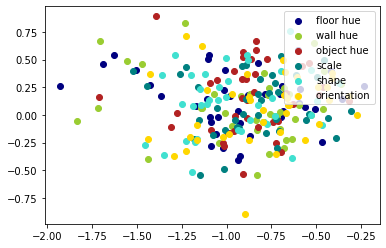

In [59]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(y[:per_fact,0], y[:per_fact,1], c='navy', label='floor hue')
ax1.scatter(y[per_fact:per_fact*2,0],y[per_fact:per_fact*2,1], c='yellowgreen', label='wall hue')
ax1.scatter(y[per_fact*2:per_fact*3,0],y[per_fact*2:per_fact*3,1], c='firebrick', label='object hue')
ax1.scatter(y[per_fact*3:per_fact*4,0],y[per_fact*3:per_fact*4,1], c='teal', label='scale')
ax1.scatter(y[per_fact*4:per_fact*5,0],y[per_fact*4:per_fact*5,1], c='turquoise', label='shape')
ax1.scatter(y[per_fact*5:,0],y[per_fact*5:,1], c='gold', label='orientation')
plt.legend(loc='upper right');
plt.show()

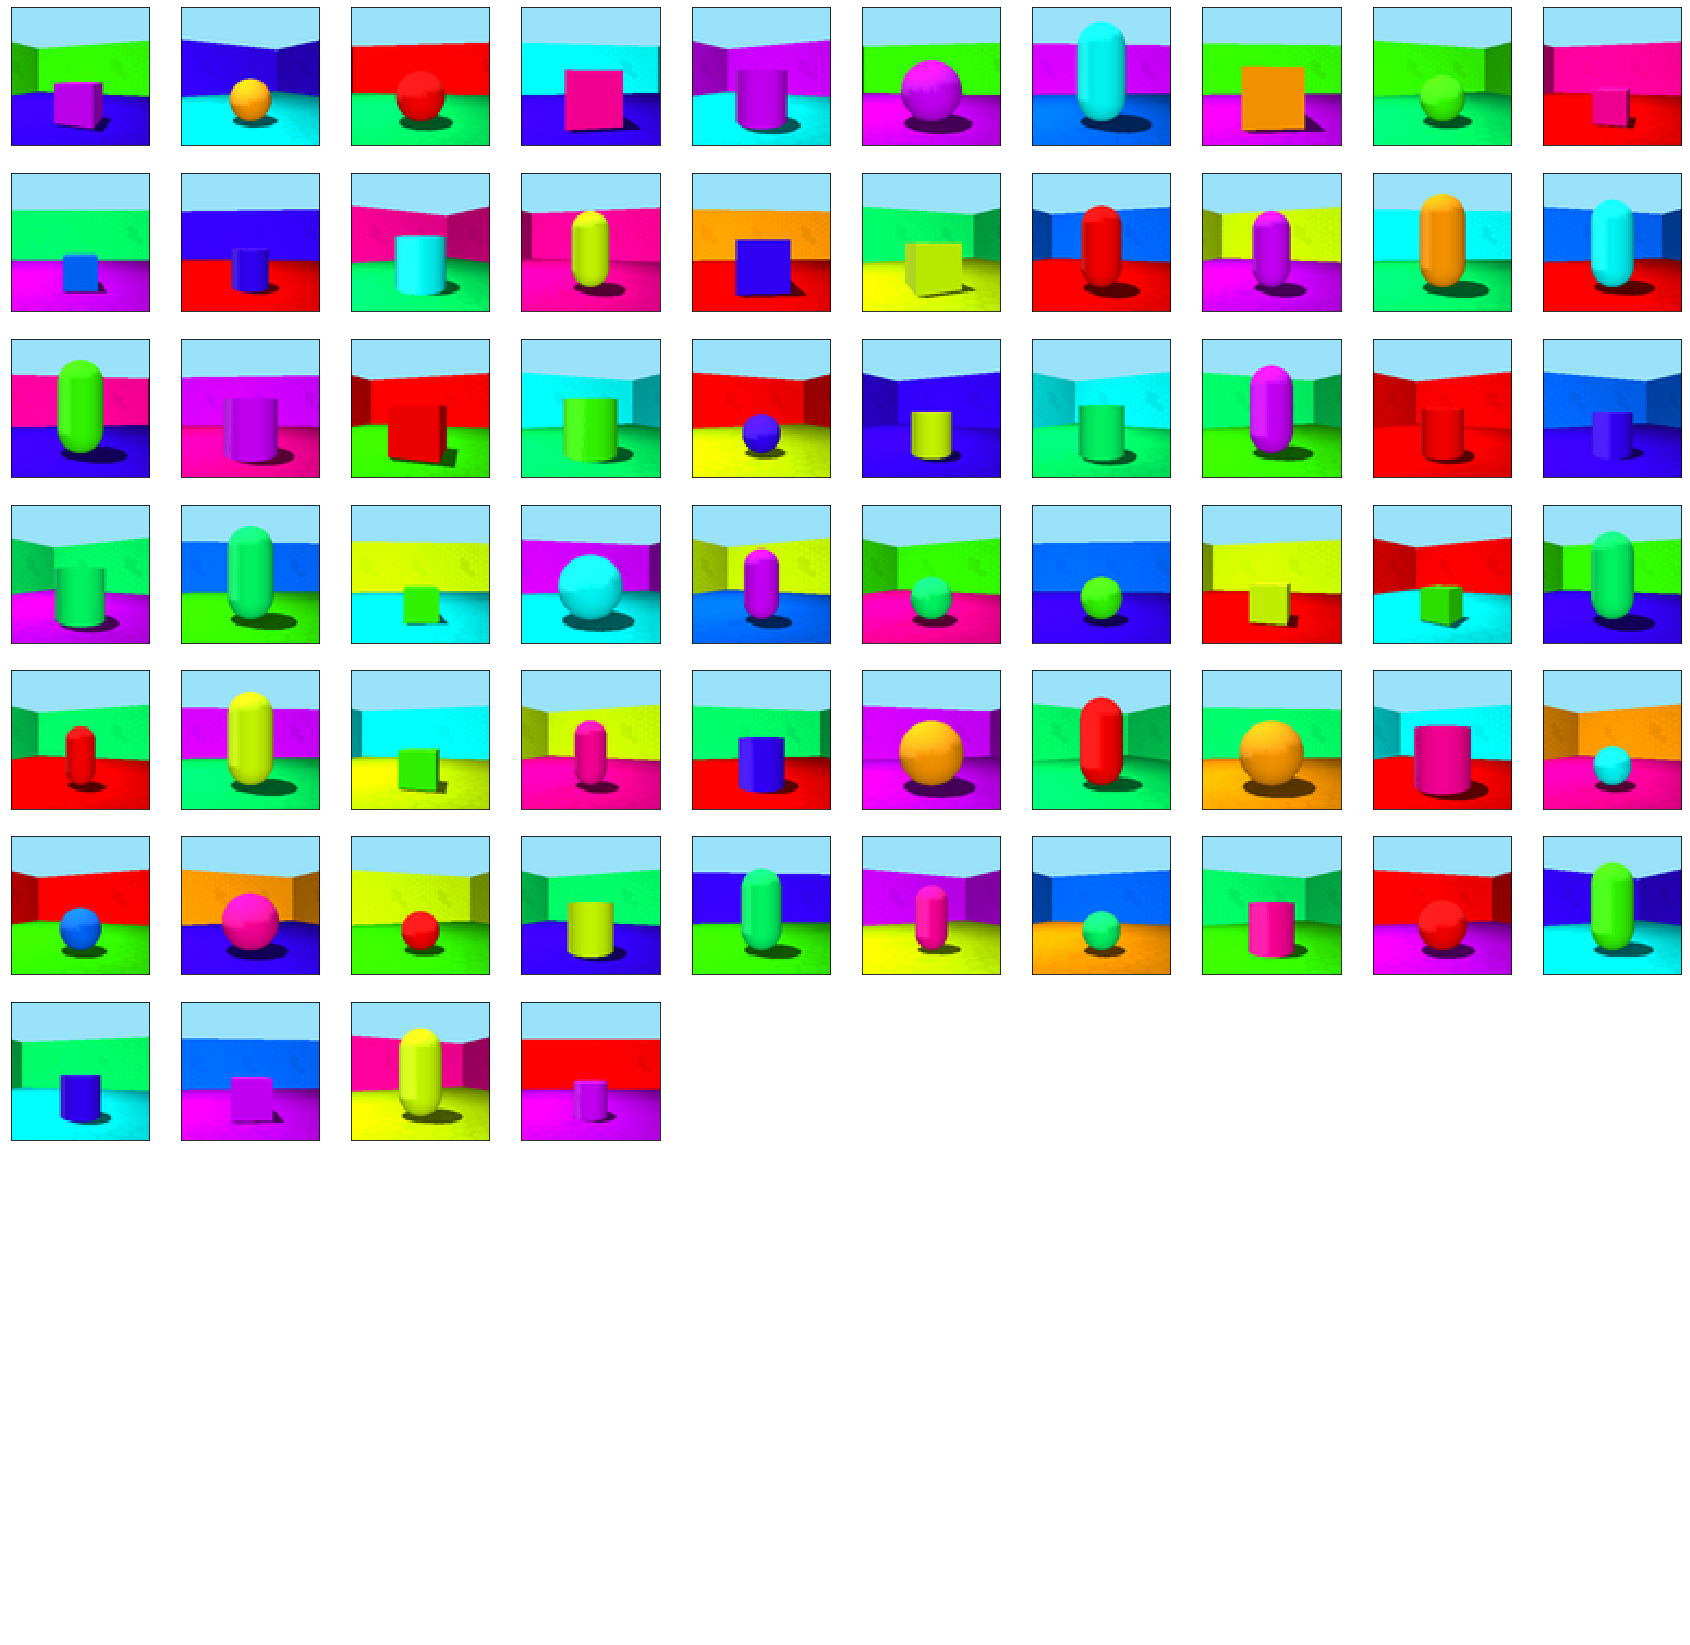

In [60]:
show_images_grid(imgs1.permute(0,2,3,1).cpu().data)

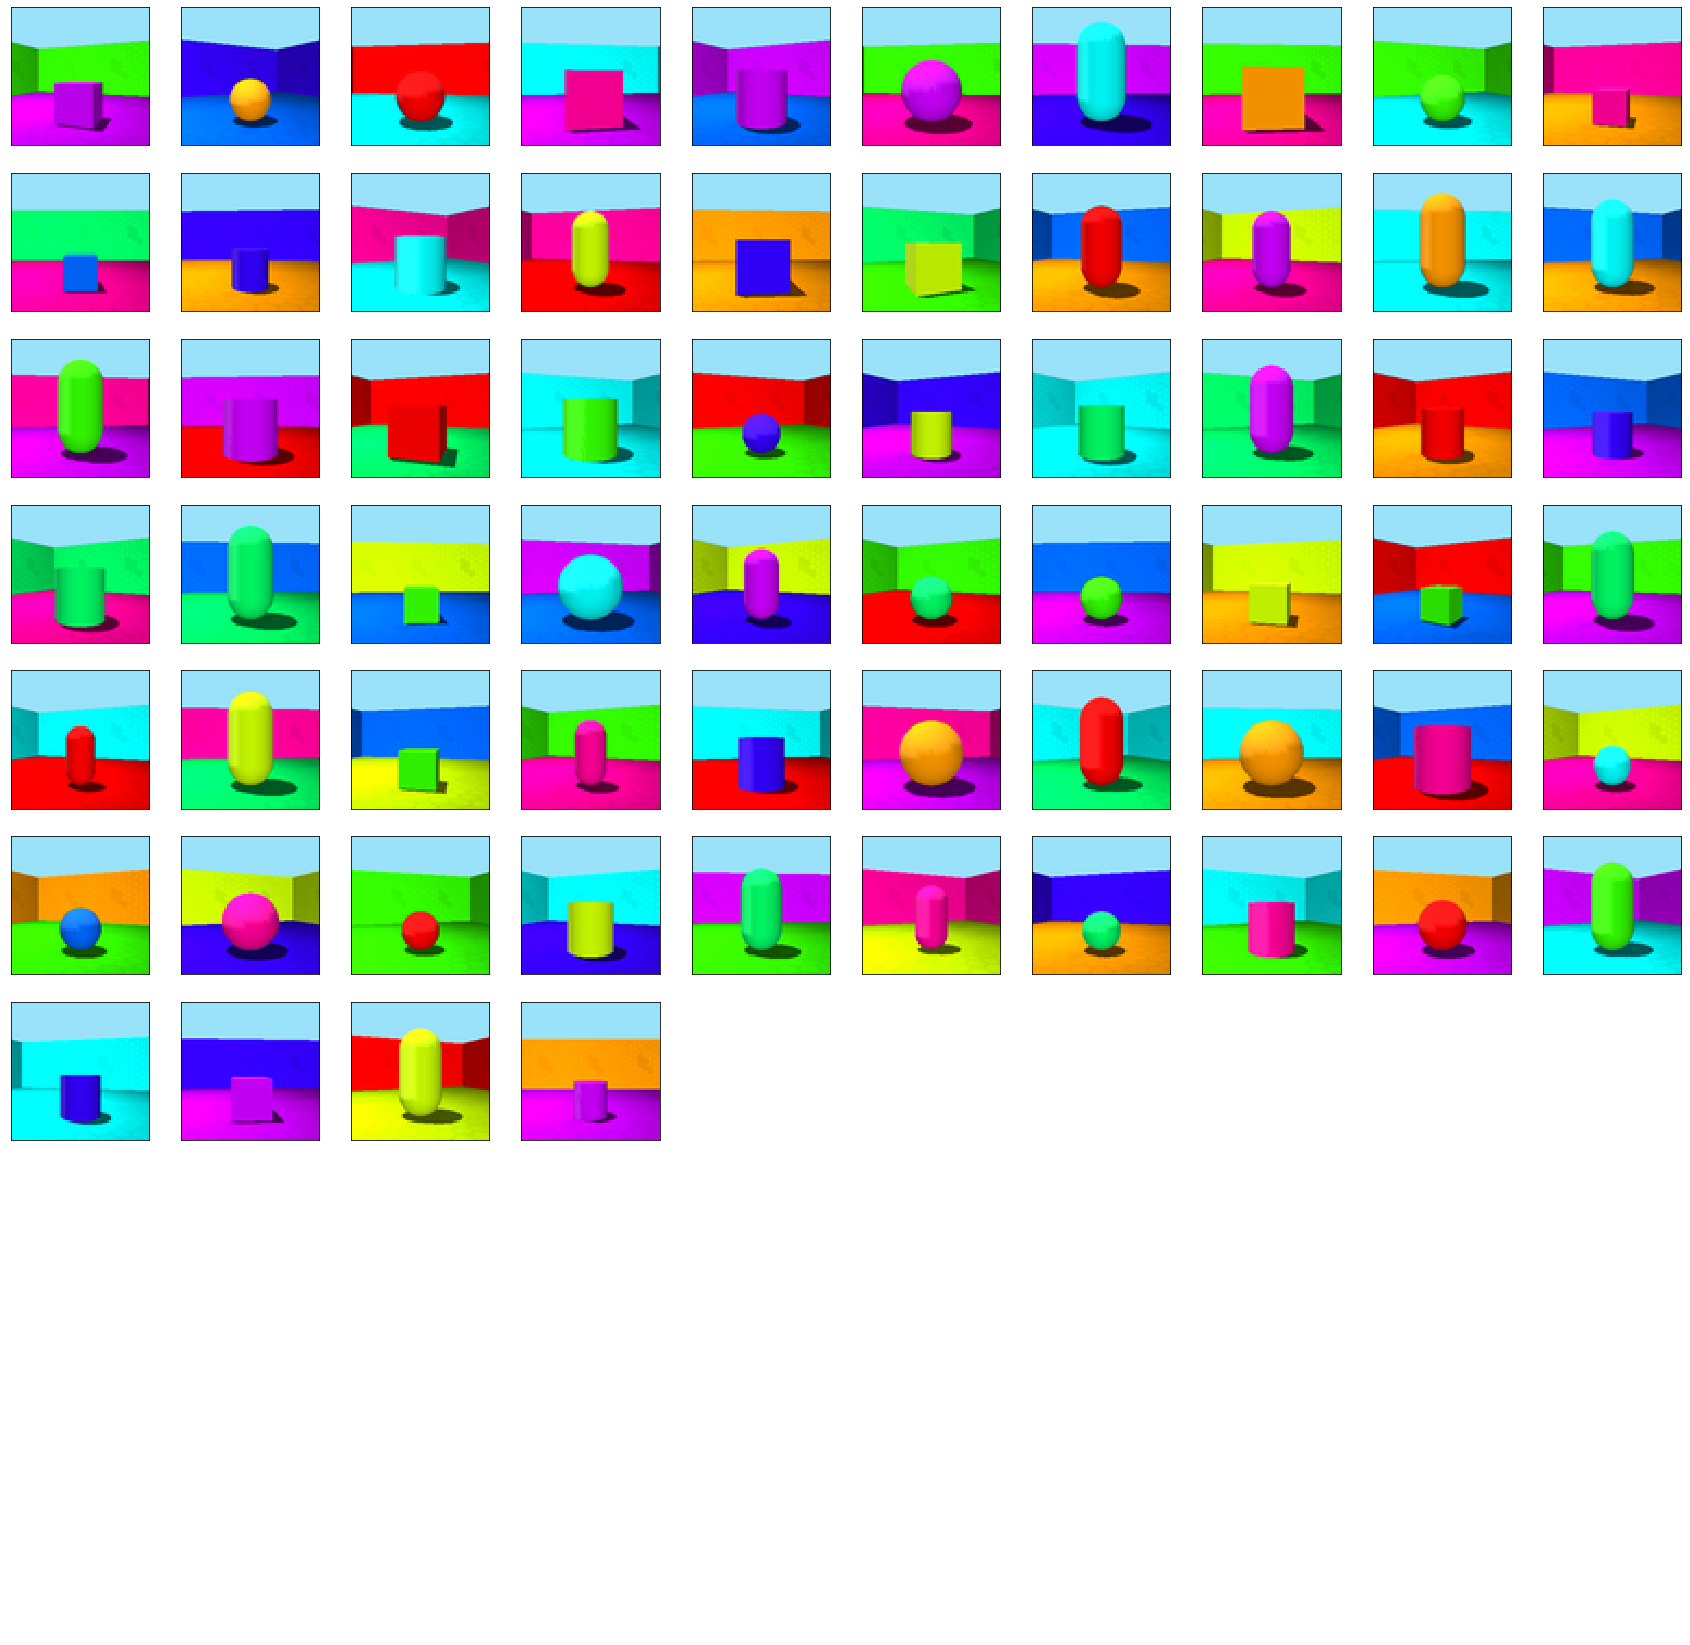

In [61]:
show_images_grid(imgs2.permute(0,2,3,1).cpu().data)

In [62]:
a = np.asarray([0.623, ])

In [63]:
print(np.mean(a))

0.623


In [64]:
print(np.std(a))

0.0


In [65]:
np.asarray([0.936, 0.729, 0.789]).mean()

0.8180000000000001

In [66]:
import torch

In [67]:
a = torch.randn(10)

In [68]:
a

tensor([-1.2174,  1.1710,  3.0680, -0.4950,  0.3505, -0.9431, -0.1302, -0.0842,
         0.8367,  0.5511])

In [69]:
a.long()

tensor([-1,  1,  3,  0,  0,  0,  0,  0,  0,  0])